<a href="https://colab.research.google.com/github/skylerlewis/nwca-wetland-remote-sensing/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages (these are the packages that are not available on the Google cloud servers)

In [ ]:
# install packages in the virtual environment
# if there are errors, force restart the environment (factory reset runtime)
!pip install -q pandas fiona shapely pyproj rtree pygeos #--upgrade --force-reinstall
!pip install -q geopandas #--upgrade --force-reinstall
!pip install -q rasterio rioxarray
!pip install -q -U PyDrive

In [ ]:
# setup for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from google drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
# alternately, mount google drive and access via "/content/drive/MyDrive/nwca/filename..."

def unzip_shapefile(filename):
    import io
    from fiona.io import ZipMemoryFile
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

# Package imports

In [ ]:
# basics
import os
import datetime as dt
from functools import reduce
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# geospatial
import shapely
import geopandas as gpd 
import rasterio as rio
import xarray as xr 
import rioxarray
global_crs = "EPSG:5070" # NAD83 CONUS ALBERS

# statistical packages
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from pandas import IndexSlice as idx

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [ ]:
# function to keep only intersecting features
def subset_by_sindex(target_features, by_features, predicate="intersects") -> gpd.GeoDataFrame:
    """ Uses one geodataframe/geometry to query another. 
            Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] """
    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

# function to generate matplotlib colormap from list
def gen_cmap(palette: list) -> mpl.colors.LinearSegmentedColormap:
    """ Returns a matplotlib colormap given a list of color strings."""
    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:
    from scipy.stats import norm, chi2
    # calculate ellipse dimensions
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        # confidence ellipse
        q = 2 * norm.cdf(n_std) - 1
        r2 = chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        # error ellipse
        width, height = 2 * n_std * np.sqrt(vals)
    #print(width, height, theta)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    return d

def quick_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    v = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.Series(v, index = df.columns)

def quick_skedplot(modelfit, title=None):
    pred_mod = modelfit.predict()
    res_mod = modelfit.resid
    fig, ax = plt.subplots(figsize=(10,6))
    x = pred_mod
    y = res_mod
    if title is None:
        plt.title("Homoskedasticity Test Plot")
    else:
        plt.title(title)
    plt.axhline(y=0, color="black", linestyle=":") 
    ax.scatter(x, y)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")  
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))
    sns.despine(trim=True)
    plt.show()

def quick_skedtest(models: list, labels=None):
    from statsmodels.compat import lzip
    from statsmodels.stats.diagnostic import het_breuschpagan
    test_names = ['LMS', 'P(LMS)', 'F', 'P(F)']
    t = []
    for m in models:
        results = het_breuschpagan(m.resid, m.model.exog)
        t.append([x for x in results])
        #print(lzip(test_names, results))
    if labels is None:
        return pd.DataFrame(t, columns=test_names)
    else:
        return pd.DataFrame(t, columns=test_names, index=labels)

def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray, n_std: int = 2, **kwargs) -> sns.axisgrid.FacetGrid:
    g = sns.jointplot(x=actual, y=predicted, **kwargs)
    std_min = min(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_max = max(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_lim = (std_min, std_max)
    g.ax_joint.set_xlim(std_lim)
    g.ax_joint.set_ylim(std_lim)
    g.ax_marg_x.set_xlim(std_lim)
    g.ax_marg_y.set_ylim(std_lim)
    sns.despine(trim=True, ax=g.ax_joint)
    sns.despine(trim=True, ax=g.ax_marg_x, left=True)
    sns.despine(trim=True, ax=g.ax_marg_y, bottom=True)
    sns.lineplot(ax=g.ax_joint, color="black", linestyle=":", x=std_lim, y=std_lim)
    g.ax_joint.add_patch(make_ellipse(x=actual, y=predicted, 
            facecolor="#5799c6", alpha=0.2, type="error", n_std=n_std))
    return g

# Import site traits (NWCA) data from CSV

In [ ]:
# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("README.csv")

# convert to pandas datafrmae with multiindex (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# create new unique id column as a combo of both 2011 and 2016 UIDs
sites["id"] = sites[("UID", "2011")].astype(str) + "-" + sites[("UID", "2016")].astype(str)
sites = sites.set_index("id")

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)
sites

varname       UID           Latitude  ... CN_Variance WetlandCat      
year         2011    2016       2011  ...        DIFF       2011  2016
id                                    ...                             
2610-204253  2610  204253  30.151190  ...    1.560116       PRLH  PRLH
2611-201075  2611  201075  32.534447  ...    0.026232         EH    EH
2669-197720  2669  197720  29.661140  ...    0.756188       PRLW  PRLW
2791-200920  2791  200920  32.393260  ...    0.261259         EH    EH
2812-197200  2812  197200  30.261785  ...    1.736944         EH    EH
...           ...     ...        ...  ...         ...        ...   ...
5910-209080  5910  209080  47.552326  ...    0.446880       PRLH  PRLH
5911-204792  5911  204792  44.862520  ...    0.774465       PRLW  PRLW
5912-202530  5912  202530  43.913349  ...    0.651941       PRLH  PRLH
5915-202530  5915  202530  43.913310  ...    0.450266       PRLH  PRLH
6146-201931  6146  201931  31.557458  ...    0.585752       PRLW  PRLW

[293 rows x 54 columns]

In [ ]:
sites

varname       UID           Latitude  ... exp_ShannonDiv                      
year         2011    2016       2011  ...           2011       2016       DIFF
id                                    ...                                     
2610-204253  2610  204253  30.151190  ...      11.101719  13.659738   2.558019
2611-201075  2611  201075  32.534447  ...       2.960032   2.157656  -0.802375
2669-197720  2669  197720  29.661140  ...      19.546573  23.290977   3.744403
2791-200920  2791  200920  32.393260  ...       4.370162   6.065851   1.695689
2812-197200  2812  197200  30.261785  ...       8.138452   6.374807  -1.763645
...           ...     ...        ...  ...            ...        ...        ...
5910-209080  5910  209080  47.552326  ...       2.414277   2.068870  -0.345407
5911-204792  5911  204792  44.862520  ...      18.210530  17.514848  -0.695682
5912-202530  5912  202530  43.913349  ...      21.634732   4.908384 -16.726348
5915-202530  5915  202530  43.913310  ...      11.686099   4.908384  -6.777715
6146-201931  6146  201931  31.557458  ...      22.741694   6.870638 -15.871056

[293 rows x 79 columns]

In [ ]:
# examples subsetting the data by year

data2011 = sites.loc[:, idx[:, "2011"]]
data2011.columns = [x[0] for x in data2011.columns]

data2016 = sites.loc[:, idx[:, "2016"]]
data2016.columns = [x[0] for x in data2016.columns]

# example reshaping
sites.stack()

varname           AnTol_prevalence  ...  XRCOV_NATSPP
id          year                    ...              
2610-204253 2011               NaN  ...     99.910000
            2016          0.359178  ...     83.109204
            DIFF               NaN  ...    -16.800796
2611-201075 2011               NaN  ...    100.000000
            2016          0.996086  ...     99.130435
...                            ...  ...           ...
5915-202530 2016          0.956509  ...     68.624952
            DIFF               NaN  ...      0.544952
6146-201931 2011               NaN  ...     98.730000
            2016          0.924539  ...     97.432421
            DIFF               NaN  ...     -1.297579

[879 rows x 21 columns]

# Spatial data setup

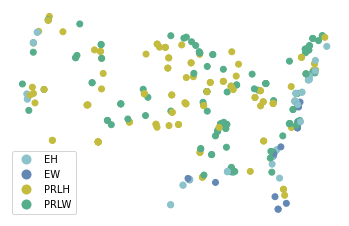

In [ ]:
# make geodataframe
sites_gdf = gpd.GeoDataFrame(sites.copy(), geometry=gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]))
# set existing CRS
sites_gdf[("geometry", "")].set_crs("EPSG:4269", inplace=True)
#sites_gdf.set_geometry(("geometry", ""), inplace=True)
# reproject
sites_gdf[("geometry", "")] = sites_gdf[("geometry", "")].to_crs(global_crs)
# set new CRS
#sites_gdf[("geometry", "")].set_crs(global_crs, inplace=True)
sites_gdf.set_geometry(("geometry", ""), inplace=True)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column=("WetlandCat","2016"), legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
plt.show()

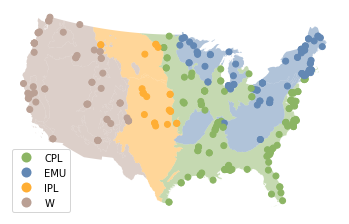

In [ ]:
# get ecoregions, convert from 9-level to 4-level for NWCA
#ecoregions = gpd.read_file(os.path.join("data", "ecoregions", "Aggr_Ecoregions_2015.shp")).to_crs(global_crs)
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)
points = gpd.GeoDataFrame(flatten_columns(gpd.GeoDataFrame(sites_gdf.geometry.copy())), crs=sites_gdf.geometry.crs)
site_regions = gpd.sjoin(points, ecoregions, how="left", op="within")

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_regions.plot(column="WSA4", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
plt.show()

# add to site table
sites["ecoregion"] = site_regions["WSA4"]

# Exploration of traits data

In [ ]:
vars_to_plot = [
        "NSPP", "ShannonDiv", 
        "CN_Ratio", #"CN_Variance", 
        "AnaerobicTol_Mean", #"AnaerobicTol_Variance", 
        "SLA_Mean", #"SLA_Variance", 
        "XN_ALIENSPP", #"XRCOV_ALIENSPP", 
        "XN_NATSPP", #"XRCOV_NATSPP", 
        "PCTN_HERB", 
]

#d = sites.stack(["year"])[["NSPP", "ShannonDiv"]].reset_index("year")
#g = sns.PairGrid(d, hue="year")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

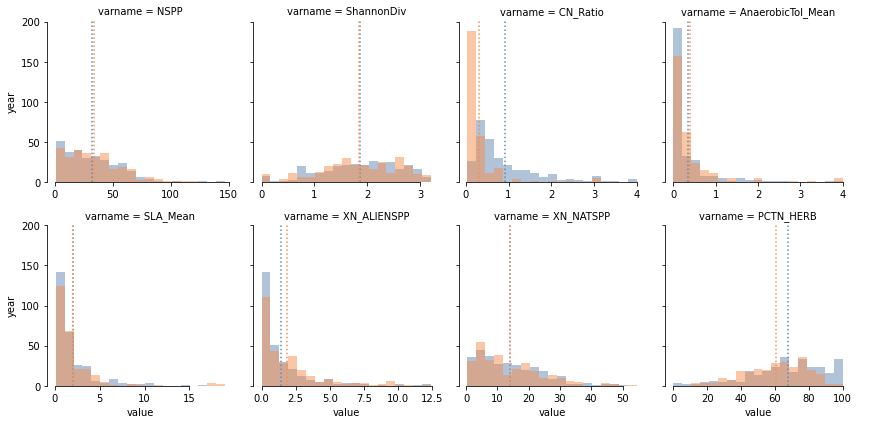

In [ ]:
def plot_hist_grouped(x, hue, n_bins=10, color=None, palette=None, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    for i, (_, x_i) in enumerate(x.groupby(hue)):
        x_mean = x_i.mean()
        #x_std = np.std(x_i)
        #x_ci_low = x_mean - x_std
        #x_ci_high = x_mean + x_std
        if palette:
            plt.axvline(x=x_mean, linestyle=":", color=palette[i])
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1, color=palette[i])
            plt.hist(x_i, bins, color=palette[i], **kwargs)
        else:
            plt.axvline(x=x_mean, linestyle=":")
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1)
            plt.hist(x_i, bins, **kwargs)


d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        [vars_to_plot]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year"])
        )
g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False)
g.map(plot_hist_grouped, "value", "year", n_bins=20, alpha=0.5, palette=["#6388B4", "#F78F4F"])
sns.despine(trim=True)
g.add_legend()

# blue = 2011, orange = 2016

In [ ]:
# right-skew (consider log): NSPP, XN_ALIENSPP, XN_NATSPP, SLA_Mean, AnaerobicTol_Mean, CN_Ratio
# left-skew (consider exp): PCTN_HERB, ShannonDiv
for v in ["NSPP", "XN_ALIENSPP", "XN_NATSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio"]:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]
for v in ["PCTN_HERB", "ShannonDiv"]:
    for y in ["2011", "2016"]:
        sites[(f"exp_{v}", y)] = np.exp(sites[v, y])
    sites[(f"exp_{v}", "DIFF")] = sites[(f"exp_{v}", "2016")] - sites[(f"exp_{v}", "2011")]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


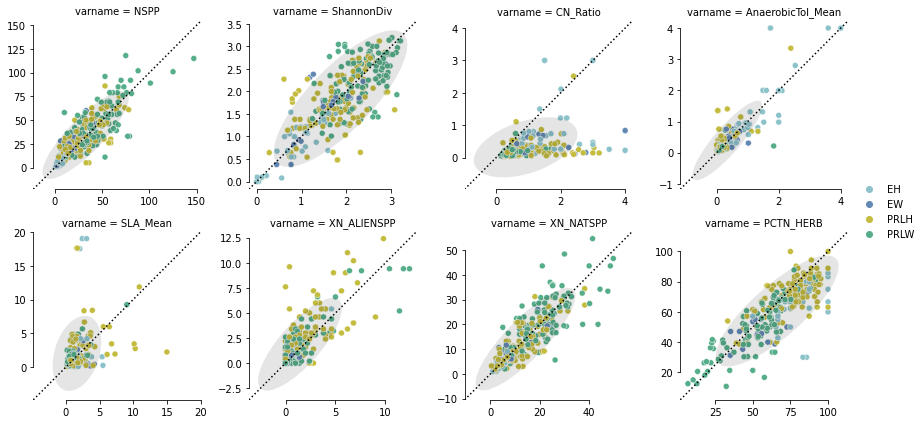

In [ ]:
def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    ax.add_patch(make_ellipse(x=x, y=y, 
        facecolor="black", alpha=0.1, type="error", n_std=2))
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(trim=True, ax=ax)
    return sp

d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .reset_index()
        .set_index(["id", "year", "WetlandCat"])
        [vars_to_plot]
        .unstack("year")
        .stack("varname")
        .reset_index(["varname", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
g.add_legend()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

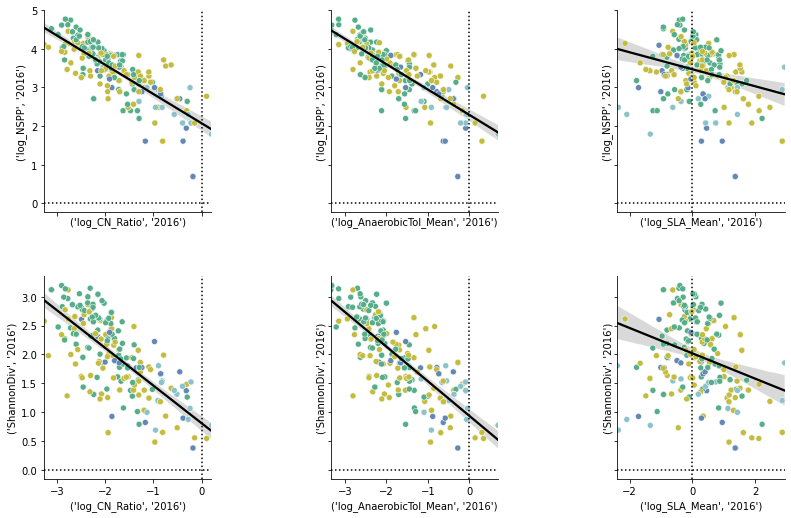

In [ ]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)

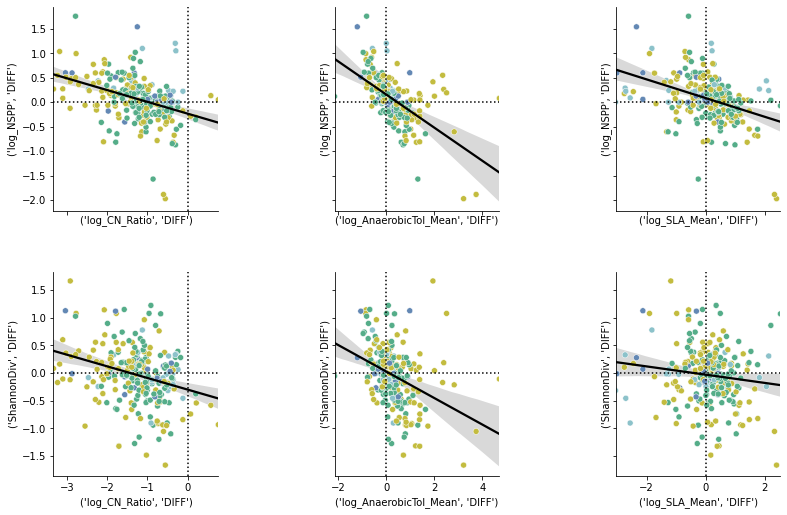

In [ ]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)

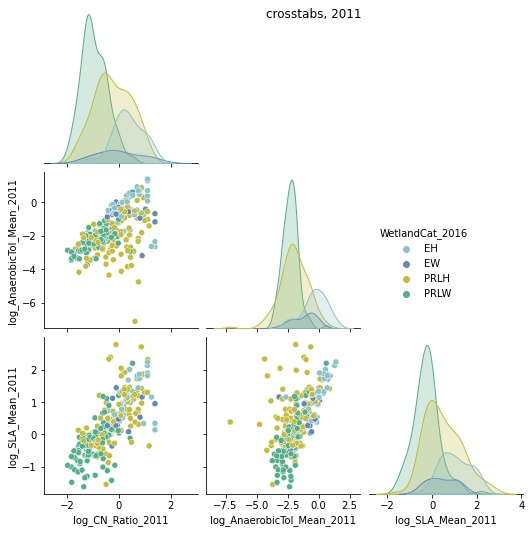

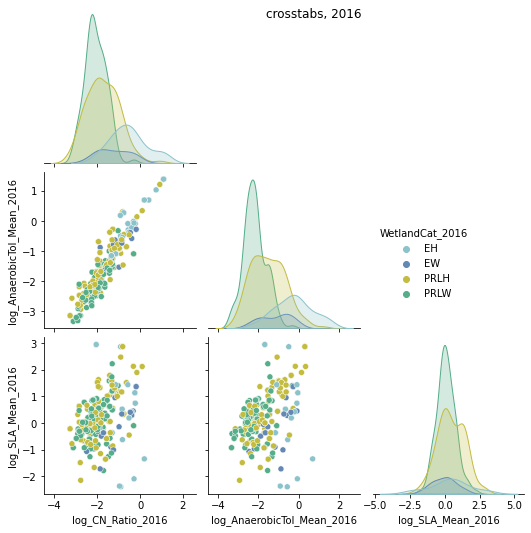

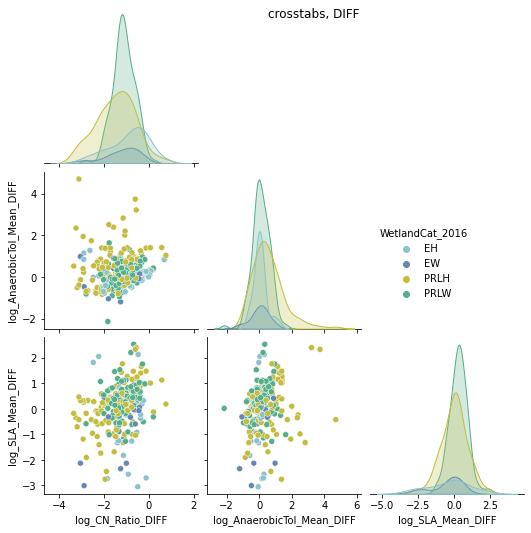

In [ ]:
for yr in ["2011", "2016", "DIFF"]:
    d = flatten_columns(sites)[["WetlandCat_2016", f"log_CN_Ratio_{yr}", f"log_AnaerobicTol_Mean_{yr}", f"log_SLA_Mean_{yr}"]] #.dropna()
    g = sns.pairplot(d, corner=True, kind="scatter", diag_kind="kde", hue="WetlandCat_2016", palette=catcolors)
    g.fig.suptitle(f"crosstabs, {yr}")
    g._legend.set_bbox_to_anchor(((3/4), (1/2)))

# note high correlation between anaerobic tol and CN ratio in 2016

## Exploratory regression

In [ ]:
for y_var in [("log_NSPP", "DIFF"), ("ShannonDiv", "DIFF")]:
    X_vars = [
        #("log_CN_Ratio", "2011"), ("log_AnaerobicTol_Mean", "2011"), ("log_SLA_Mean", "2011"),
        ("log_CN_Ratio", "DIFF"), ("log_AnaerobicTol_Mean", "DIFF"), ("log_SLA_Mean", "DIFF"),
        ]

    df = sites[[y_var] + X_vars].dropna()
    y = df[y_var]
    X = df[X_vars].assign(Intercept=1)

    print(sm.OLS(endog=y, exog=X).fit().summary2())

                      Results: Ordinary least squares
Model:                OLS                    Adj. R-squared:       0.487   
Dependent Variable:   ('log_NSPP', 'DIFF')   AIC:                  146.3579
Date:                 2021-07-06 16:02       BIC:                  160.6006
No. Observations:     260                    Log-Likelihood:       -69.179 
Df Model:             3                      F-statistic:          82.87   
Df Residuals:         256                    Prob (F-statistic):   1.71e-37
R-squared:            0.493                  Scale:                0.10124 
---------------------------------------------------------------------------
                            Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
log_CN_Ratio_DIFF          -0.1716   0.0285  -6.0146 0.0000 -0.2278 -0.1154
log_AnaerobicTol_Mean_DIFF -0.2977   0.0265 -11.2468 0.0000 -0.3498 -0.2456
log_SLA_Mean_DIFF          -0.1052

                     Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.662   
Dependent Variable:    log_NSPP_2016       AIC:                   272.0686
Date:                  2021-07-06 16:12    BIC:                   286.3420
No. Observations:      262                 Log-Likelihood:        -132.03 
Df Model:              3                   F-statistic:           171.2   
Df Residuals:          258                 Prob (F-statistic):    4.48e-61
R-squared:             0.666               Scale:                 0.16290 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   2.0889   0.0730 28.6098 0.0000  1.9451  2.2327
log_CN_Ratio_2016          -0.3578   0.0820 -4.3661 0.0000 -0.5192 -0.1964
log_AnaerobicTol_Mean_2016 -0.3955   0.0726 -5.

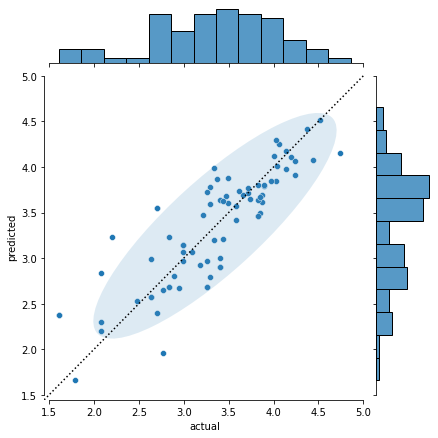

In [ ]:
f = "log_NSPP_2016 ~ log_CN_Ratio_2016 + log_AnaerobicTol_Mean_2016 + log_SLA_Mean_2016"

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit()

print(results.summary2())
print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual")
g.ax_joint.set_ylabel("predicted")
plt.show()

# save result to dataframe
#y_pred = y_test.reset_index().join(pd.Series(y_pred.flatten(), name="y_pred")).set_index("id")

                     Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.580   
Dependent Variable:    ShannonDiv_2016     AIC:                   306.1467
Date:                  2021-07-06 16:12    BIC:                   320.4201
No. Observations:      262                 Log-Likelihood:        -149.07 
Df Model:              3                   F-statistic:           121.2   
Df Residuals:          258                 Prob (F-statistic):    5.36e-49
R-squared:             0.585               Scale:                 0.18553 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.8651   0.0779 11.1020 0.0000  0.7116  1.0185
log_CN_Ratio_2016          -0.1048   0.0875 -1.1987 0.2318 -0.2771  0.0674
log_AnaerobicTol_Mean_2016 -0.5275   0.0775 -6.

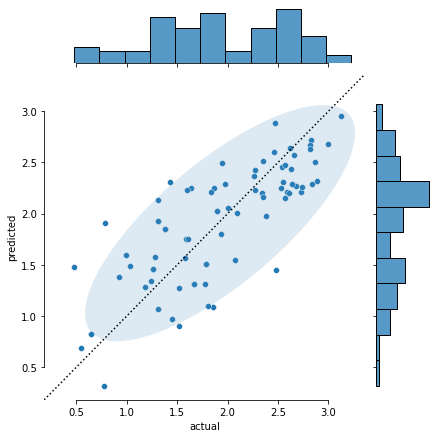

In [ ]:
f = "ShannonDiv_2016 ~ log_CN_Ratio_2016 + log_AnaerobicTol_Mean_2016 + log_SLA_Mean_2016" 

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit()

print(results.summary2())
print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual")
g.ax_joint.set_ylabel("predicted")
plt.show()

                     Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.563   
Dependent Variable:    log_NSPP_DIFF       AIC:                   112.0256
Date:                  2021-07-06 16:12    BIC:                   158.1129
No. Observations:      256                 Log-Likelihood:        -43.013 
Df Model:              12                  F-statistic:           28.39   
Df Residuals:          243                 Prob (F-statistic):    1.01e-39
R-squared:             0.584               Scale:                 0.086317
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.5184   0.1375 -3.7695 0.0002 -0.7894 -0.2475
C(WetlandCat_2011)[T.EW]   -0.0836   0.0971 -0.8603 0.3904 -0.2749  0.1078
C(WetlandCat_2011)[T.PRLH] -0.1425   0.0766 -1.

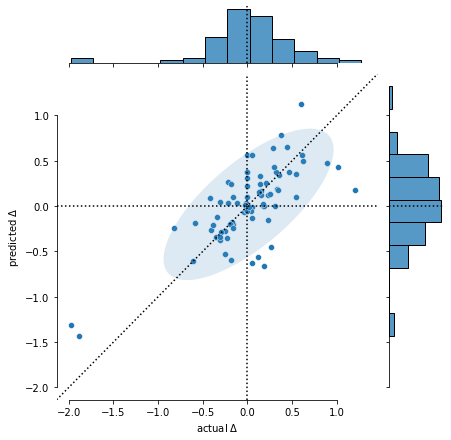

In [ ]:
f = "log_NSPP_DIFF ~ log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF + C(WetlandCat_2011) + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 + C(ecoregion)"

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit()

print(results.summary2())
print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()

                     Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.248   
Dependent Variable:    ShannonDiv_DIFF     AIC:                   314.4414
Date:                  2021-07-06 16:12    BIC:                   360.5287
No. Observations:      256                 Log-Likelihood:        -144.22 
Df Model:              12                  F-statistic:           8.006   
Df Residuals:          243                 Prob (F-statistic):    1.33e-12
R-squared:             0.283               Scale:                 0.19032 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.4759   0.2042 -2.3302 0.0206 -0.8782 -0.0736
C(WetlandCat_2011)[T.EW]    0.0014   0.1442  0.0095 0.9925 -0.2828  0.2855
C(WetlandCat_2011)[T.PRLH]  0.0677   0.1138  0.

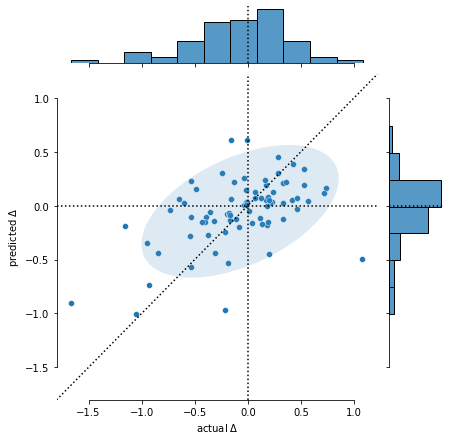

In [ ]:
f = "ShannonDiv_DIFF ~ log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF + C(WetlandCat_2011) + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 + C(ecoregion)"

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit()

print(results.summary2())
print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()